In [1]:
import numpy as np  
import pandas as pd 
from PIL import Image # converting images into arrays

In [2]:
df_can = pd.read_excel(
    'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/Canada.xlsx',
    sheet_name='Canada by Citizenship',
    skiprows=range(20),
    skipfooter=2)

print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


In [5]:
# clean up the dataset to remove unnecessary columns (eg. REG) 
df_can.drop(['AREA','REG','DEV','Type','Coverage'], axis = 1, inplace = True)

# let's rename the columns so that they make sense
df_can.rename (columns = {'OdName':'Country', 'AreaName':'Continent','RegName':'Region'}, inplace = True)

# for sake of consistency, let's also make all column labels of type string
df_can.columns = list(map(str, df_can.columns))

# set the country name as index - useful for quickly looking up countries using .loc method
df_can.set_index('Country', inplace = True)

# add total column
df_can['Total'] =  df_can.loc[:,'1980':'2013'].sum(axis = 1)

# years that we will be using in this lesson - useful for plotting later on
years = list(map(str, range(1980, 2014)))
print ('data dimensions:', df_can.shape)

data dimensions: (195, 38)


# Visualizing Data using Matplotlib<a id="4"></a>


In [6]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # needed for waffle Charts

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.4.3


# Waffle Charts <a id="6"></a>

A `waffle chart` is an interesting visualization that is normally created to display progress toward goals. It is commonly an effective option when you are trying to add interesting visualization features to a visual that consists mainly of cells, such as an Excel dashboard.


In [7]:
# let's create a new dataframe for these three countries 
df_dsn = df_can.loc[['Denmark', 'Norway', 'Sweden'], :]

# let's take a look at our dataframe
df_dsn

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,Europe,Northern Europe,Developed regions,272,293,299,106,93,73,93,...,62,101,97,108,81,92,93,94,81,3901
Norway,Europe,Northern Europe,Developed regions,116,77,106,51,31,54,56,...,57,53,73,66,75,46,49,53,59,2327
Sweden,Europe,Northern Europe,Developed regions,281,308,222,176,128,158,187,...,205,139,193,165,167,159,134,140,140,5866


Unfortunately, unlike R, `waffle` charts are not built into any of the Python visualization libraries. Therefore, we will learn how to create them from scratch.


**Step 1.** The first step into creating a waffle chart is determing the proportion of each category with respect to the total.


In [19]:
# compute the proportion of each category with respect to the total
total_values = df_dsn['Total'].sum()
category_proportions = df_dsn['Total'] / total_values

# print out proportions
pd.DataFrame({"Category Proportion": category_proportions})

,Category Proportion
Country,
Denmark,0.322557
Norway,0.192409
Sweden,0.485034


Now it would very inefficient to repeat these seven steps every time we wish to create a `waffle` chart. So let's combine all seven steps into one function called *create_waffle_chart*. This function would take the following parameters as input:

> 1.  **categories**: Unique categories or classes in dataframe.
> 2.  **values**: Values corresponding to categories or classes.
> 3.  **height**: Defined height of waffle chart.
> 4.  **width**: Defined width of waffle chart.
> 5.  **colormap**: Colormap class
> 6.  **value_sign**: In order to make our function more generalizable, we will add this parameter to address signs that could be associated with a value such as %, $, and so on. **value_sign** has a default value of empty string.


In [20]:
def create_waffle_chart(categories, values, height, width, colormap, value_sign=''):

    # compute the proportion of each category with respect to the total
    total_values = sum(values)
    category_proportions = [(float(value) / total_values) for value in values]

    # compute the total number of tiles
    total_num_tiles = width * height # total number of tiles
    print ('Total number of tiles is', total_num_tiles)
    
    # compute the number of tiles for each catagory
    tiles_per_category = [round(proportion * total_num_tiles) for proportion in category_proportions]

    # print out number of tiles per category
    for i, tiles in enumerate(tiles_per_category):
        print (df_dsn.index.values[i] + ': ' + str(tiles))
    
    # initialize the waffle chart as an empty matrix
    waffle_chart = np.zeros((height, width))

    # define indices to loop through waffle chart
    category_index = 0
    tile_index = 0

    # populate the waffle chart
    for col in range(width):
        for row in range(height):
            tile_index += 1

            # if the number of tiles populated for the current category 
            # is equal to its corresponding allocated tiles...
            if tile_index > sum(tiles_per_category[0:category_index]):
                # ...proceed to the next category
                category_index += 1       
            
            # set the class value to an integer, which increases with class
            waffle_chart[row, col] = category_index
    
    # instantiate a new figure object
    fig = plt.figure()

    # use matshow to display the waffle chart
    colormap = plt.cm.coolwarm
    plt.matshow(waffle_chart, cmap=colormap)
    plt.colorbar()

    # get the axis
    ax = plt.gca()

    # set minor ticks
    ax.set_xticks(np.arange(-.5, (width), 1), minor=True)
    ax.set_yticks(np.arange(-.5, (height), 1), minor=True)
    
    # add dridlines based on minor ticks
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    plt.xticks([])
    plt.yticks([])

    # compute cumulative sum of individual categories to match color schemes between chart and legend
    values_cumsum = np.cumsum(values)
    total_values = values_cumsum[len(values_cumsum) - 1]

    # create legend
    legend_handles = []
    for i, category in enumerate(categories):
        if value_sign == '%':
            label_str = category + ' (' + str(values[i]) + value_sign + ')'
        else:
            label_str = category + ' (' + value_sign + str(values[i]) + ')'
            
        color_val = colormap(float(values_cumsum[i])/total_values)
        legend_handles.append(mpatches.Patch(color=color_val, label=label_str))

    # add legend to chart
    plt.legend(
        handles=legend_handles,
        loc='lower center', 
        ncol=len(categories),
        bbox_to_anchor=(0., -0.2, 0.95, .1)
    )
    plt.show()

Now to create a `waffle` chart, all we have to do is call the function `create_waffle_chart`. Let's define the input parameters:


In [21]:
width = 40 # width of chart
height = 10 # height of chart

categories = df_dsn.index.values # categories
values = df_dsn['Total'] # correponding values of categories

colormap = plt.cm.coolwarm # color map class

And now let's call our function to create a `waffle` chart.


Total number of tiles is 400
Denmark: 129
Norway: 77
Sweden: 194


<Figure size 432x288 with 0 Axes>

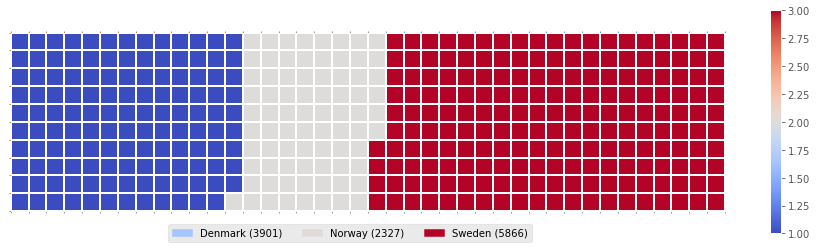

In [22]:
create_waffle_chart(categories, values, height, width, colormap)

# Word Clouds <a id="8"></a>

`Word` clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.


In [23]:
# install wordcloud
! pip3 install wordcloud

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158781 sha256=c83f99e85a6e32103acd7a5a1f329449f6e214289aed07d60c4320824ef30094
  Stored in directory: /Users/sumit/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud
Wordcloud is installed and imported!


`Word` clouds are commonly used to perform high-level analysis and visualization of text data. Accordinly, let's digress from the immigration dataset and work with an example that involves analyzing text data. Let's try to analyze a short novel written by **Lewis Carroll** titled *Alice's Adventures in Wonderland*. Let's go ahead and download a *.txt* file of the novel.


In [24]:
import urllib

# open the file and read it into a variable alice_novel
alice_novel = urllib.request.urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/Data%20Files/alice_novel.txt').read().decode("utf-8")

Next, let's use the stopwords that we imported from `word_cloud`. We use the function *set* to remove any redundant stopwords.


In [25]:
stopwords = set(STOPWORDS)

Create a word cloud object and generate a word cloud. For simplicity, let's generate a word cloud using only the first 2000 words in the novel.


In [26]:
# instantiate a word cloud object
alice_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
alice_wc.generate(alice_novel)

Awesome! Now that the `word` cloud is created, let's visualize it.


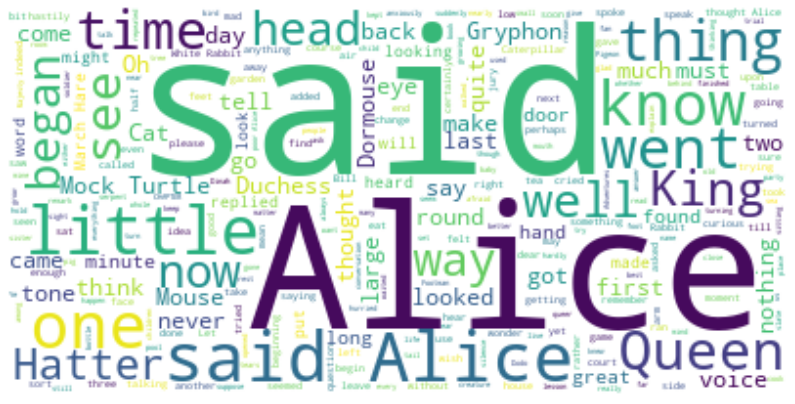

In [29]:
fig = plt.figure(figsize=(14, 18))

# display the cloud
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Much better! However, **said** isn't really an informative word. So let's add it to our stopwords and re-generate the cloud.


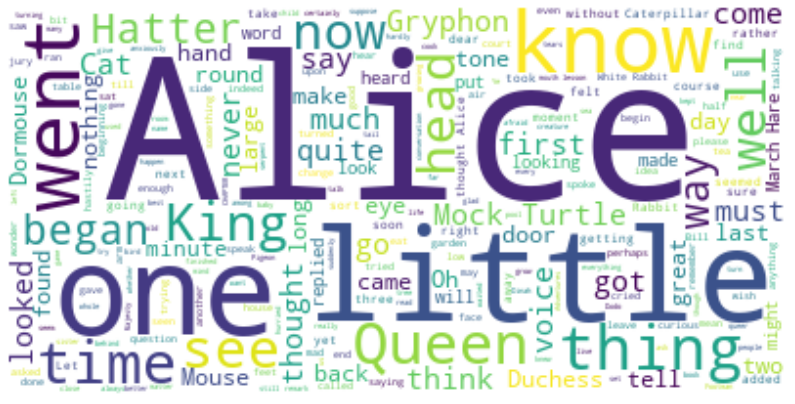

In [30]:
stopwords.add('said') # add the words said to stopwords

# re-generate the word cloud
alice_wc.generate(alice_novel)

# display the cloud
fig = plt.figure(figsize=(14, 18))

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Excellent! This looks really interesting! Another cool thing you can implement with the `word_cloud` package is superimposing the words onto a mask of any shape. Let's use a mask of Alice and her rabbit. We already created the mask for you, so let's go ahead and download it and call it *alice_mask.png*.


In [31]:
# save mask to alice_mask
alice_mask = np.array(Image.open(urllib.request.urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DV0101EN-SkillsNetwork/labs/Module%204/images/alice_mask.png')))

Let's take a look at how the mask looks like.


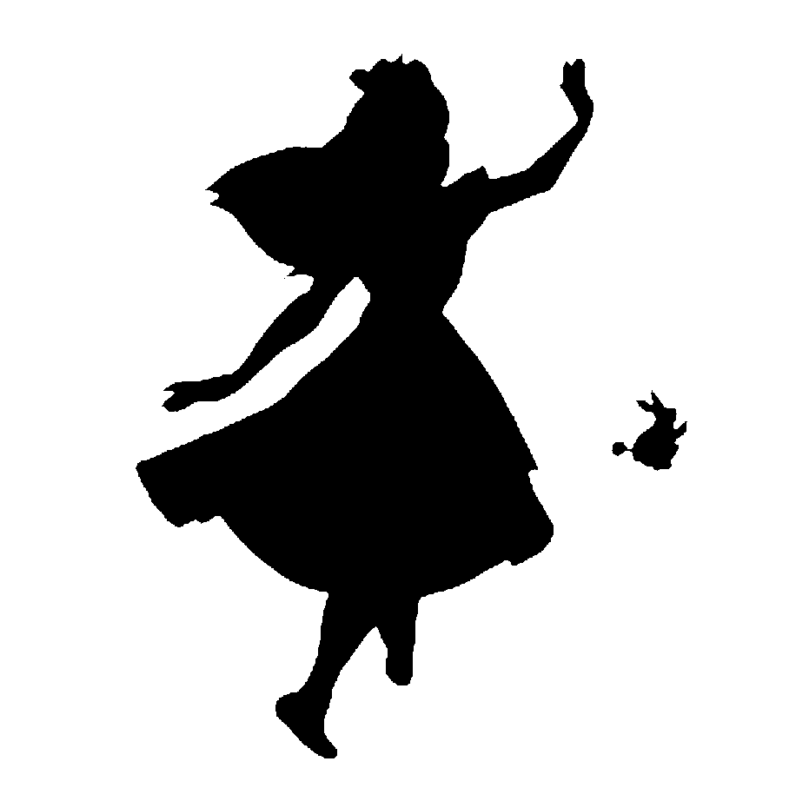

In [32]:
fig = plt.figure(figsize=(14, 18))

plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

Shaping the `word` cloud according to the mask is straightforward using `word_cloud` package. For simplicity, we will continue using the first 2000 words in the novel.


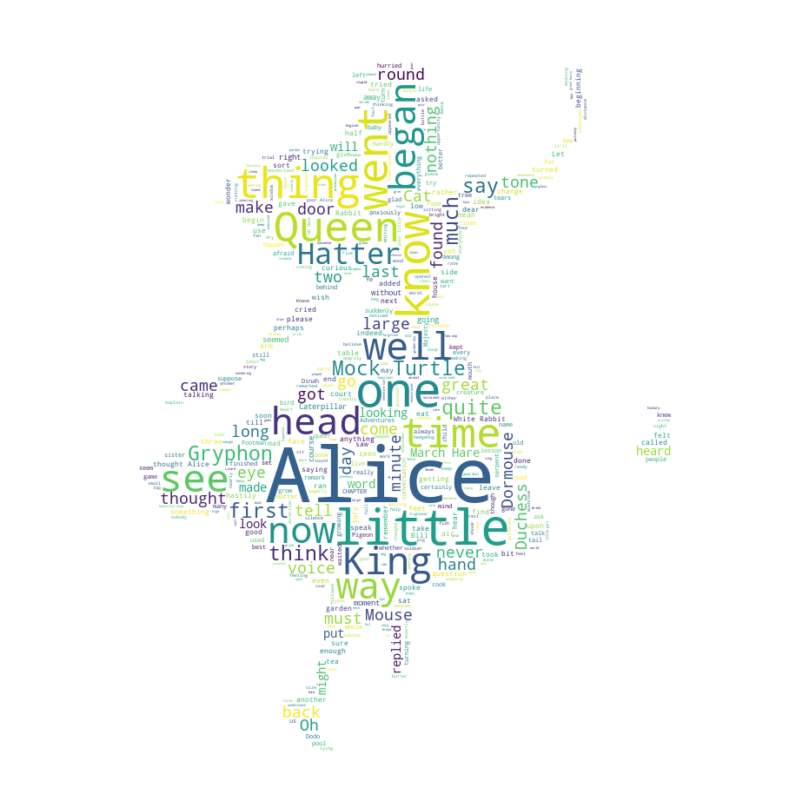

In [33]:
# instantiate a word cloud object
alice_wc = WordCloud(background_color='white', max_words=2000, mask=alice_mask, stopwords=stopwords)

# generate the word cloud
alice_wc.generate(alice_novel)

# display the word cloud
fig = plt.figure(figsize=(14, 18))

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Let's recall how our data looks like.


In [34]:
df_can.head()

,Continent,Region,DevName,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,Total
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Asia,Southern Asia,Developing regions,16,39,39,47,71,340,496,...,3436,3009,2652,2111,1746,1758,2203,2635,2004,58639
Albania,Europe,Southern Europe,Developed regions,1,0,0,0,0,0,1,...,1223,856,702,560,716,561,539,620,603,15699
Algeria,Africa,Northern Africa,Developing regions,80,67,71,69,63,44,69,...,3626,4807,3623,4005,5393,4752,4325,3774,4331,69439
American Samoa,Oceania,Polynesia,Developing regions,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6
Andorra,Europe,Southern Europe,Developed regions,0,0,0,0,0,0,2,...,0,1,1,0,0,0,0,1,1,15


And what was the total immigration from 1980 to 2013?


In [35]:
total_immigration = df_can['Total'].sum()
total_immigration

6409153

Using countries with single-word names, let's duplicate each country's name based on how much they contribute to the total immigration.


In [36]:
max_words = 90
word_string = ''
for country in df_can.index.values:
    # check if country's name is a single-word name
    if country.count(" ") == 0:
        repeat_num_times = int(df_can.loc[country, 'Total'] / total_immigration * max_words)
        word_string = word_string + ((country + ' ') * repeat_num_times)

# display the generated text
word_string

'China China China China China China China China China Colombia Egypt France Guyana Haiti India India India India India India India India India Jamaica Lebanon Morocco Pakistan Pakistan Pakistan Philippines Philippines Philippines Philippines Philippines Philippines Philippines Poland Portugal Romania '

We are not dealing with any stopwords here, so there is no need to pass them when creating the word cloud.


In [37]:
# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

Word cloud created!


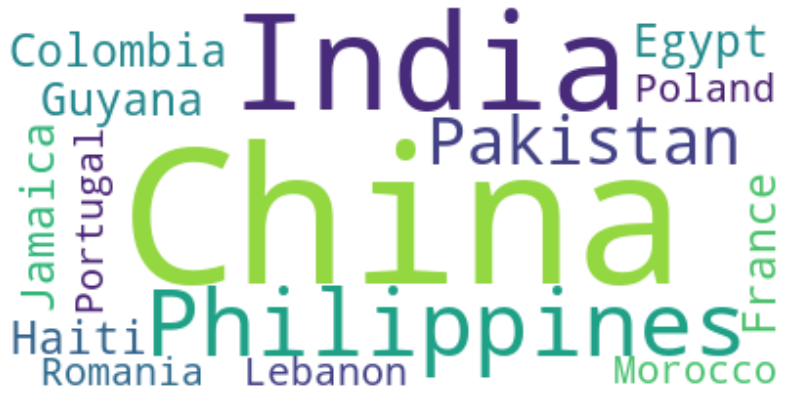

In [38]:
# display the cloud
plt.figure(figsize=(14, 18))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

According to the above word cloud, it looks like the majority of the people who immigrated came from one of 15 countries that are displayed by the word cloud. One cool visual that you could build, is perhaps using the map of Canada and a mask and superimposing the word cloud on top of the map of Canada. That would be an interesting visual to build!


# Regression Plots 


Let's first install *seaborn*


In [39]:
# install seaborn
! pip3 install seaborn

# import library
import seaborn as sns

print('Seaborn installed and imported!')

Seaborn installed and imported!


Create a new dataframe that stores that total number of landed immigrants to Canada per year from 1980 to 2013.


In [40]:
# we can use the sum() method to get the total population per year
df_tot = pd.DataFrame(df_can[years].sum(axis=0))

# change the years to type float (useful for regression later on)
df_tot.index = map(float, df_tot.index)

# reset the index to put in back in as a column in the df_tot dataframe
df_tot.reset_index(inplace=True)

# rename columns
df_tot.columns = ['year', 'total']

# view the final dataframe
df_tot.head()

,year,total
0,1980.0,99137
1,1981.0,110563
2,1982.0,104271
3,1983.0,75550
4,1984.0,73417


<AxesSubplot:xlabel='year', ylabel='total'>

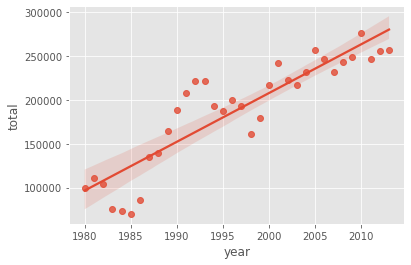

In [41]:
sns.regplot(x='year', y='total', data=df_tot)

You can always customize the marker shape, so instead of circular markers, let's use `+`.


And finally increase the font size of the tickmark labels, the title, and the x- and y-labels so they don't feel left out!


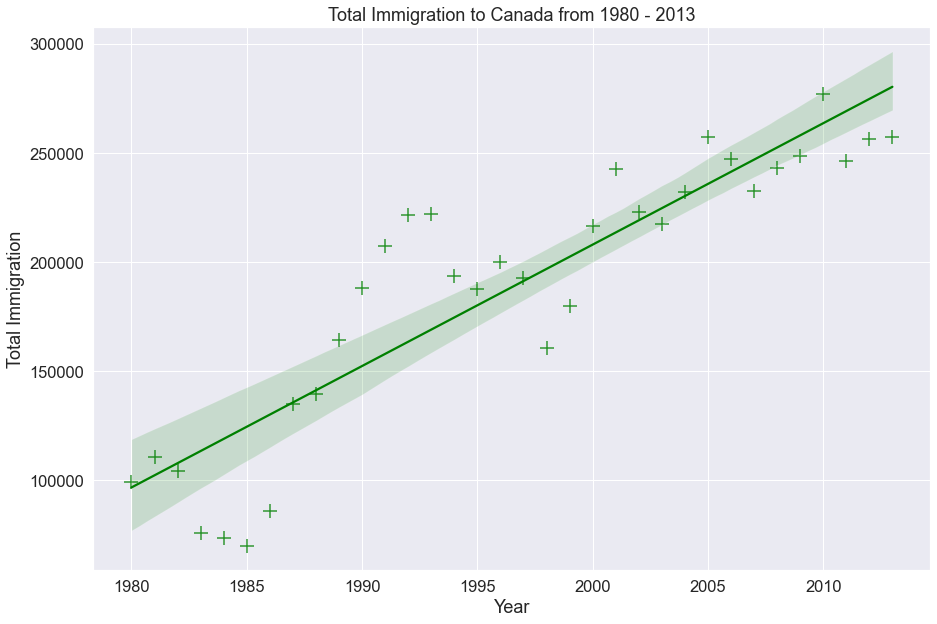

In [46]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')
plt.show()

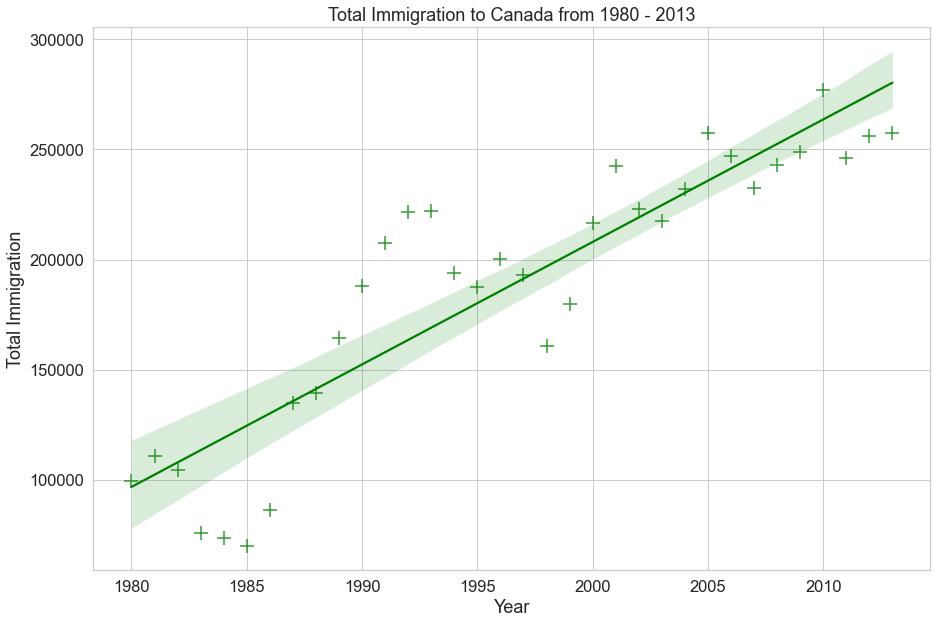

In [48]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='year', y='total', data=df_tot, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigration to Canada from 1980 - 2013')
plt.show()

**Question**: Use seaborn to create a scatter plot with a regression line to visualize the total immigration from Denmark, Sweden, and Norway to Canada from 1980 to 2013.


Text(0.5, 1.0, 'Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')

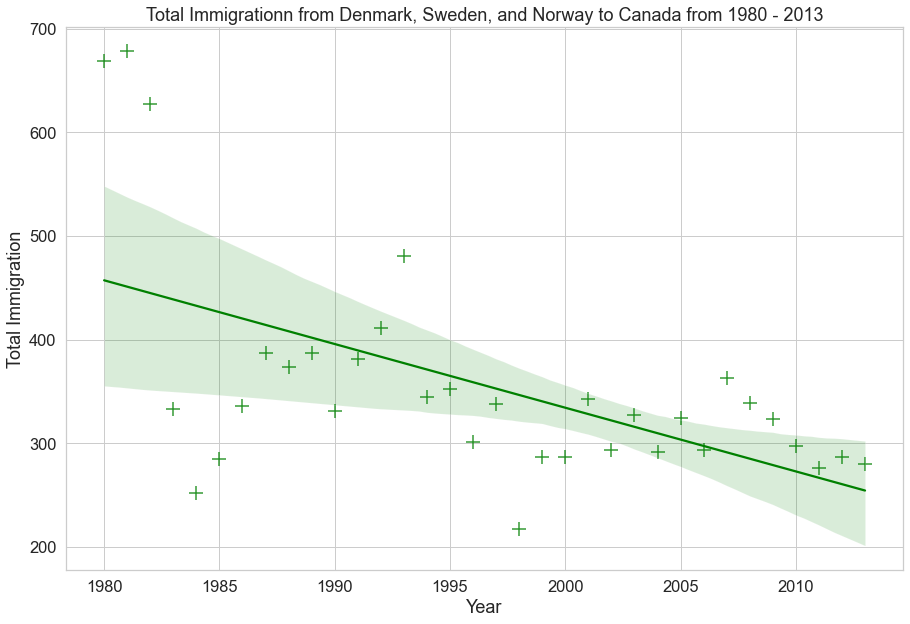

In [49]:
### type your answer here
df_countries = df_can.loc[["Denmark", "Sweden", "Norway"],years].transpose()
df_total = pd.DataFrame(df_countries.sum(axis=1))
df_total.reset_index(inplace=True)
df_total.columns =['year','total']
df_total['year'] = df_total['year'].astype(int)

plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

ax = sns.regplot(x='year', y='total', data=df_total, color='green', marker='+', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Immigration')
ax.set_title('Total Immigrationn from Denmark, Sweden, and Norway to Canada from 1980 - 2013')